<img  src="nb_images/yelp-logo.png" style="width:18%; hieght:20%;" align="left"/>

<h1>HELP</h1>

<p class="sub-title"> Machine learning for uncovering inisight in your business and market </p>

The `yelp_academic_dataset` (find it <a href = "https://www.yelp.com/dataset_challenge">here</a>) provides a rich dataset for determining how business can become better competitors and fill wants of consumers in a more educated and useful way.

For our project we have 3 core purposes:

1. Design a metric to determine "competitiveness" between two companies. (See <a>Topic Modeling</a>)
2. Determine the `competitive` radius of a company. (See <a>Computing Competitive Radi</a>
3. Predict a company's future success and determine what about a company is liked or disliked.  (See <a>Predicting Rating Change</a>, <a>Sentiment Analysis</a>, and <a>Topic Modeling</a>)

In [5]:
from yelp_utils.data_manager import get_business_reviews, get_business_name
from yelp_utils.preprocess_reviews import tokenize, get_nouns
import numpy as np
from pymongo import MongoClient
import nltk
import re

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import HTML
import urllib2

HTML(filename='nb_images/jupyter.css')

<h1 class='main_header'>Topic Modeling</h1>
<hr>

Within machine learning and natural language processing, a *topic model* is a type of statistical model for discovering abstract topics, or groups, that occur in a collection of documents. These topics are latent structures of the documents. The premise behind most of these models is that certain words will be more frequent in certain topics. For example, a document about sports is likly to contain the words "touchdown" and "runner", while a document about mathematics is much less likly to contain these words.

For the Yelp data we will use this genre of model in several ways:
 - Grouping similar reviews for a business
 - Finding similar business competitors
 - Discovering importatntant trends in reviews

<h2 class="section_header">Review Clustering</h2>

First, we will discover "documents" in the reviews. This can be interpreted as the different subjects and types of reviews users leave. Uncovering this latent structure could help a business see the categories that stand out to customers, for better of worse.

In [13]:
# Select a well known business for us to perform tests on
BIZ_ID = 'eAc9Vd6loOgRQolMXQt6FA'
print get_business_name(BIZ_ID)

Mandalay Bay Resort & Casino


In [14]:
# Make a list of reviews and stars
review_list = np.array([x['text'] for x in get_business_reviews(BIZ_ID)])
star_list = np.array([x['stars'] for x in get_business_reviews(BIZ_ID)])

In [18]:
#Let us consider a particular review
print review_list[9]

# Tokenize those reviews so they can be processed
print tokenize(review_list[9])

Rum Jungle is a pretty amazing bar. Worth stopping by in the afternoon just to sit in and look at the decor and fountains. Glad I went.
[u'rum', u'jungle', u'is', u'a', u'pretty', u'amazing', u'bar', u'worth', u'stopping', u'by', u'in', u'the', u'afternoon', u'just', u'to', u'sit', u'in', u'and', u'look', u'at', u'the', u'decor', u'and', u'fountains', u'glad', u'i', u'went']


## Term Frequency-Inverse Document Frequency (Tf-idf)

After cleaning and tokenizing the text from reviews we can create teh term frequencey-inverse document frequency matrix.  This matrix counts the occurences of every important word in every document. Then like the picture bellow it stacks these vectors so the it is one matrix with the dimension (NUM_DOCUMENTS X VOCAB_SIZE).

<img src='nb_images/tf-idf.png'>

Once this matrix is created we then weight the words that occur frequently in the document but not in the corpus higher.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [21]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(review_list)
vocab_list = tfidf_vectorizer.get_feature_names()

## Clustering Documents

Below we cluster reviews (aka documents) by the vocabulary used in them. The goal of this method is to enable us to determine what reviews regard or talk about the most. This will allow us to produce a more refined (and useful) view on the star ratings associated with review. 

In [23]:
NUM_CLUSTERS = 4 #One problem with this method is it is very sensitive to this param given a buisness
k_means = KMeans(NUM_CLUSTERS)
k_means.fit(tfidf_matrix)
labels = np.array(k_means.labels_.tolist())

In [24]:
for i in range(NUM_CLUSTERS):
    print "Cluster %d: " % i
    print "-"*25
    print "Top Words: ",
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1] 
    for ind in order_centroids[i,:6]:
        print vocab_list[ind] + ", ",
    print "\nNumber of Reviews: %d" % np.sum(labels == i)
    print "Avg Stars: %.2f" % np.mean(star_list[labels == i])
    print "\n"

Cluster 0: 
-------------------------
Top Words:  room,  hotel,  check,  service,  stay,  time,  
Number of Reviews: 708
Avg Stars: 2.69


Cluster 1: 
-------------------------
Top Words:  mandalay,  bay,  mandalay bay,  hotel,  stay,  vegas,  
Number of Reviews: 437
Avg Stars: 3.40


Cluster 2: 
-------------------------
Top Words:  hotel,  great,  place,  nice,  casino,  rooms,  
Number of Reviews: 846
Avg Stars: 3.56


Cluster 3: 
-------------------------
Top Words:  pool,  lazy,  river,  lazy river,  wave,  wave pool,  
Number of Reviews: 314
Avg Stars: 3.85




The above result is pretty amazing! 

People who left reviews about attributes regarding the room or the service rated the service at a whole 1.16 points below those who had something to say about the pool. This could potentially give Mandalay Bay motivation to focus on getting all of its guests to the pool at some point. 

##  Visualizing Clusters
To see a visualization of these clusters see: (##TODO:ADD GIT) 

<h2 class="section_header">Latent Dirichlet Allocation</h2>

LDA is a probabalistic topic model that assumes documents are a mixture of topics and each word in the document is atttributabe to the documents topics. This is useful because given 10 topics, a new topic can be assigned probabilities of being in each topic. By concatinating all the reviews for one business into a document we can then train this model to discover different types of businesses. This can be used to find similar reviews for a business or a businesses competitors by looking at the similarity of their topic distribution.

In [25]:
from gensim import corpora, models, similarities 

In [26]:
#preprocess
tokenized_docs = [get_nouns(tokenize(x)) for x in review_list]

In [27]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [28]:
lda = models.LdaModel(corpus, num_topics=7, id2word=dictionary, 
                      update_every=5, chunksize=5, passes=6)

After looking at the words assosiated with the different topics the folowing groups were determined.

In [30]:
topic_labels = [
    'Families and Groups',
    'Rooms and Physical Aspects',
    'Entertainment and Events',
    'Customer Service',
    'Pool and Casino',
    'Resturant at Water Show',
    'Transportation'
]

In [31]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (Families and Groups)
--------------------
part
bathroom
mini
option
cabana
mlife
you're
anything
suites
table
fridge
request
member
brother
they're
notch
monte
spots
party
attention

Topic 1 (Rooms and Physical Aspects)
--------------------
room
i
hotel
time
stay
view
floor
pool
bed
weekend
lot
kids
vegas
suite
shower
tub
everything
hotels
strip
beds

Topic 2 (Entertainment and Events)
--------------------
pool
beach
pools
river
area
food
wave
people
chairs
drinks
house
place
fun
years
michael
blues
check
everyone
hotel
sand

Topic 3 (Customer Service)
--------------------
i
line
valet
fee
night
customer
minutes
security
hotel
resort
show
car
water
desk
guests
room
card
hour
food
time

Topic 4 (Pool and Casino)
--------------------
i
room
service
night
people
desk
front
coffee
staff
price
buffet
manager
someone
nights
issue
time
phone
rooms
hours
years

Topic 5 (Resturant at Water Show)
--------------------
mandalay
bay
hotel
day
rooms
resort
i
experience
strip
vegas
bathroom

##  Visualizing LDA
To see a cool visualization of this method see: (##TODO:ADD GIT) 

## LDA For Determining Business type

Next we apply LDA to reviews from 5 different types of businesses. The goal of this is to discover these labels.

Though we do not accomplish it here (it turns out to be extremely computationally expensive) the ultimate goal of this section would be to develop a "business signal" which will help determine exactly how competitive one company is to another. With this, the competitive radius, and our sentiment analysis we will be able to determine exactly who the biggest threats to a business is and how exactly they are doing worse than their best competitors. 

In [32]:
# Connect to database
client = MongoClient()
db = client.yelp

In [47]:
# Get examples from distinct businesses for training
different_categories = ['Automotive', 'Hair Salons', 'Pets', 'Medical Centers', 'Butcher']

category_dict = {}
for category in different_categories:
    cursor = db.businesses.find({'categories': {"$elemMatch":{"$in":[category]}}}).limit(100)
    total_reviews = []
    for business in cursor:
        biz_reviews = [x['text'] for x in get_business_reviews(business['business_id'])]
        concat_biz_review = ' '.join(biz_reviews)
        cleaned_review = get_nouns(tokenize(concat_biz_review))
        total_reviews.append(cleaned_review)
    category_dict[category] = total_reviews

In [48]:
#preprocess
tokenized_docs = []
category_labels = []
for i, category in enumerate(different_categories):
    tokenized_docs += category_dict[category]
    category_labels += [i] * len(category_dict[category])

In [49]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=.05, no_above=0.6)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [50]:
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, 
                      update_every=1, chunksize=100, passes=10)

TODO: ADD A DESCRIPTION OF WHY THIS NEXT CELL IS COOL

In [51]:
lda.show_topics()

[(0,
  u'0.022*"khorsandi" + 0.013*"laser" + 0.009*"spine" + 0.007*"massage" + 0.006*"procedure" + 0.005*"treatment" + 0.004*"rudd" + 0.004*"chiropractor" + 0.004*"disc" + 0.004*"kim"'),
 (1,
  u'0.015*"care" + 0.014*"dr" + 0.014*"doctor" + 0.013*"dog" + 0.013*"hospital" + 0.010*"office" + 0.009*"room" + 0.008*"surgery" + 0.008*"people" + 0.008*"vet"'),
 (2,
  u'0.026*"meat" + 0.013*"food" + 0.010*"meats" + 0.010*"store" + 0.010*"butcher" + 0.010*"quality" + 0.009*"beef" + 0.008*"selection" + 0.007*"shop" + 0.006*"chicken"'),
 (3,
  u'0.054*"hair" + 0.022*"salon" + 0.016*"cut" + 0.011*"color" + 0.011*"job" + 0.010*"appointment" + 0.009*"stylist" + 0.008*"experience" + 0.007*"haircut" + 0.007*"i\'ve"'),
 (4,
  u'0.023*"car" + 0.010*"work" + 0.008*"experience" + 0.008*"minutes" + 0.007*"customer" + 0.006*"insurance" + 0.006*"way" + 0.006*"people" + 0.006*"day" + 0.005*"hours"')]

In [52]:
topic_labels = [
    'medical centers',
    'butcher',
    'hair salons',
    'pets',
    'automotive',  
]
#These just happen to be the order that the LDA method outputs in, it won't be important for the 
#buisness signal because lda will return the components of the signal in a consistent order

In [53]:
topics_matrix = lda.show_topics(formatted=False, num_words=10)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (medical centers)
--------------------
khorsandi
laser
spine
massage
procedure
treatment
rudd
chiropractor
disc
kim

Topic 1 (butcher)
--------------------
care
dr
doctor
dog
hospital
office
room
surgery
people
vet

Topic 2 (hair salons)
--------------------
meat
food
meats
store
butcher
quality
beef
selection
shop
chicken

Topic 3 (pets)
--------------------
hair
salon
cut
color
job
appointment
stylist
experience
haircut
i've

Topic 4 (automotive)
--------------------
car
work
experience
minutes
customer
insurance
way
people
day
hours


In [54]:
accuracy = 0
for i, category in enumerate(different_categories):
    results = []
    num_category = len(category_dict[category])
    for review in category_dict[category]:
        doc_bow = dictionary.doc2bow(review)
        distribution = lda[doc_bow]
        percents = np.array([x[1] for x in distribution])
        max_indx = np.argmax(percents)
        results.append(distribution[max_indx][0])
    classes, amounts = np.unique(results, return_counts=True)
    print "Classes: %7s, Amount: %s" % (classes, amounts)

Classes: [0 1 2 3 4], Amount: [ 1  1  4  1 93]
Classes:   [1 3], Amount: [ 2 98]
Classes: [1 2 3 4], Amount: [91  6  1  2]
Classes: [0 1 3 4], Amount: [ 1 90  2  7]
Classes:     [2], Amount: [100]


<h1 class='main_header'>Sentiment Analysis</h1>
<hr>

Sentiment analysis is a branch of natural language processing that aims to systematically identify, extract, and quantify affective states and subjective information. The prototypical example is classifying if a review is positive or negative. For a bisunesses Yelp reviews we will use this so we can determine what is included in the most negative and most positive reviews. This can give concise information on what needs to be fixed and what is going well.

There are several teqniques for doing this...

<h2 class='section_header'>Naive Bayes</h2>

Because of the complex nature of working with text, historically the simple naive bayes model has been the standard for sentiment anaysis. The text is read in and then transformed into a simple bag of words. This gives the probability of words ocurring given a certain sentiment which is then used by naive bayes.

$$ P(c\vert x) = \frac{P(x\vert c)P(c)}{P(x)}$$
$$ P(c\vert x) = P(x_1\vert c) \times P(x_2\vert c)\times \dots P(x_n\vert c) \times P(c)$$

In [57]:
from yelp_utils.preprocess_reviews import prepare_classify
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
#TODO: ADD MORE CLASSIFIERS

In [ ]:
# Create trainging set of positive and negative examples
pos_list, neg_list = prepare_classify(700)
train = pos_list[:500] + neg_list[:500]
test = pos_list[500:] + neg_list[500:]

In [ ]:
naiveBayes = NaiveBayesClassifier(train)

In [ ]:
naiveBayes.show_informative_features()

In [ ]:
naiveBayes.accuracy(test_set)

<h1 class='main_header'>Estimating Competitive Radi</h1>
<hr>

For a more indepth disscussion of each of these methods see: TODO: REFERENCE AUXILERY


In [1]:
from yelp_utils.data_manager import get_all_reviews_by_user_for_city, get_average_lat_and_long,\
get_max_distacne_from_mid, get_radius_from_review_centers_dict, clean_reviewer_average_radius_with_get_clusters
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

For this demonstraion we will use Henderson, Nevada (a city next to Las Vegas) to visualize our methods. 

In [2]:
henderson_reviews = get_all_reviews_by_user_for_city("Henderson")

In [3]:
def get_all_centers_as_array(reviews_dict):
    x_centers_list = []
    y_centers_list = []
    associated_id = []
    for uid, user_review in reviews_dict.iteritems():
        if len(user_review) == 1:
            continue #We don't care about single reviewers! They give us no information.
        x, y = get_average_lat_and_long(user_review)
        x_centers_list.append(x)
        y_centers_list.append(y)
        associated_id.append(uid)
    return np.array([x_centers_list, y_centers_list]).T, associated_id

def get_all_points_as_array(reviews_dict):
    x_list = []
    y_list = []
    associated_id = []
    for uid, user_review in reviews_dict.iteritems():
        x, y = get_average_lat_and_long(user_review)
        for review in user_review:
            x_list.append(review[0])
            y_list.append(review[1])
    return np.array([x_list, y_list]).T

def visualize_all_points(reviews_dict, city_loc=(36.0395, -114.9817)):
    #Default values set to be appropriate for henderson
    points = get_all_points_as_array(reviews_dict)
    plt.scatter(points[:, 0], points[:, 1])
    plt.ylabel('Longitude')
    plt.xlabel('Latitude')
    if city_loc:
        plt.scatter(city_loc[0], city_loc[1], c='r')
    return plt

def visualize_centers(reviews_dict, city_loc=(36.0395, -114.9817)):
    #Default values set to be appropriate for henderson
    centers = get_all_centers_as_array(reviews_dict)[0]
    plt.scatter(centers[:, 0], centers[:, 1])
    if city_loc:
        plt.scatter(city_loc[0], city_loc[1], c='r')
    plt.ylabel('Longitude')
    plt.xlabel('Latitude')
    return plt

## Dealing with Outliers

Our dataset is filled with some pretty awful and sometimes very unperdictable datapoints.

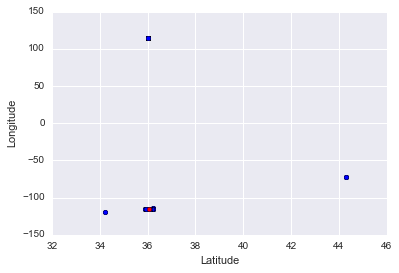

In [6]:
visualize_all_points(henderson_reviews).show()

### Naive K means Outlier Removal
This approach, is stupid. But time was spent devoloping it so feel free to check it out <a> HERE TODO: </a>. 

### Cleaning Outliers with EllipticEnvelope

Below you can see we clean our data with the "EllipticEnvelope". This enables us to remove all those weird blips that are thousands of miles from Hendreson.

In [9]:
def clean_reviewer_average_radius_with_EllipticEnvelope(reviews):
    """A function to clean outliers using the EllipticEnvelope Method"""
    good_points = {}
    classifier = EllipticEnvelope(contamination=0.005)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    inlier_indexes = np.where(classifier.predict(centers) != -1)
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

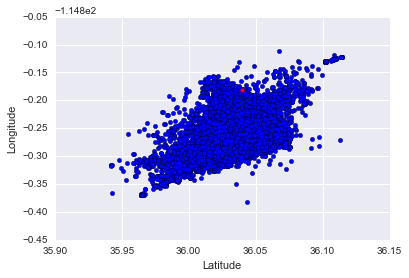

In [13]:
EllipticEnvelope_cleaned = clean_reviewer_average_radius_with_EllipticEnvelope(henderson_reviews)
visualize_centers(EllipticEnvelope_cleaned).show()

### Random Forest for Anomaly Detection (Isolation Forest)


Below you can see we clean our data with the "IsolationForest". This enables us to remove all those weird blips that are thousands of miles from Hendreson.

In [11]:
def clean_reviewer_average_radius_with_IsolationForest(reviews):
    rng = np.random.RandomState(42)
    good_points = {}
    classifier = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    des_on = classifier.decision_function(centers)
    #Within four standard deviations of the decision_function
    inlier_indexes = np.where(abs(des_on - np.mean(des_on))  < 4*np.std(des_on))
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

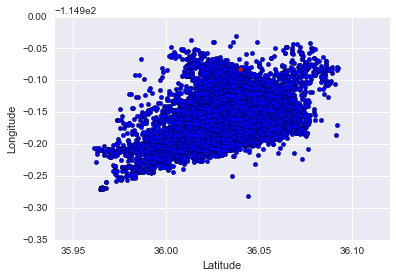

In [14]:
IsolationForest_cleaned = clean_reviewer_average_radius_with_IsolationForest(henderson_reviews)
visualize_centers(IsolationForest_cleaned).show()

As you can see the latter method includes a bit more points futher from the "center of henderson" (That that red dot) It is probably a better representation of all the reviews in Henderson. This is likely an issue cause by our hyper-parameter choices (one of them is what percentage of our data ar outliers) and the fact that the former method can fit much more exactly (it's not based on dictance from a point, but rather an (as the name might suggest elipse). 

## Calculating Radi
We've done alot with Henderson, so we will use Phoenix in this section, to make sure we don't limit our selection by a single city. 

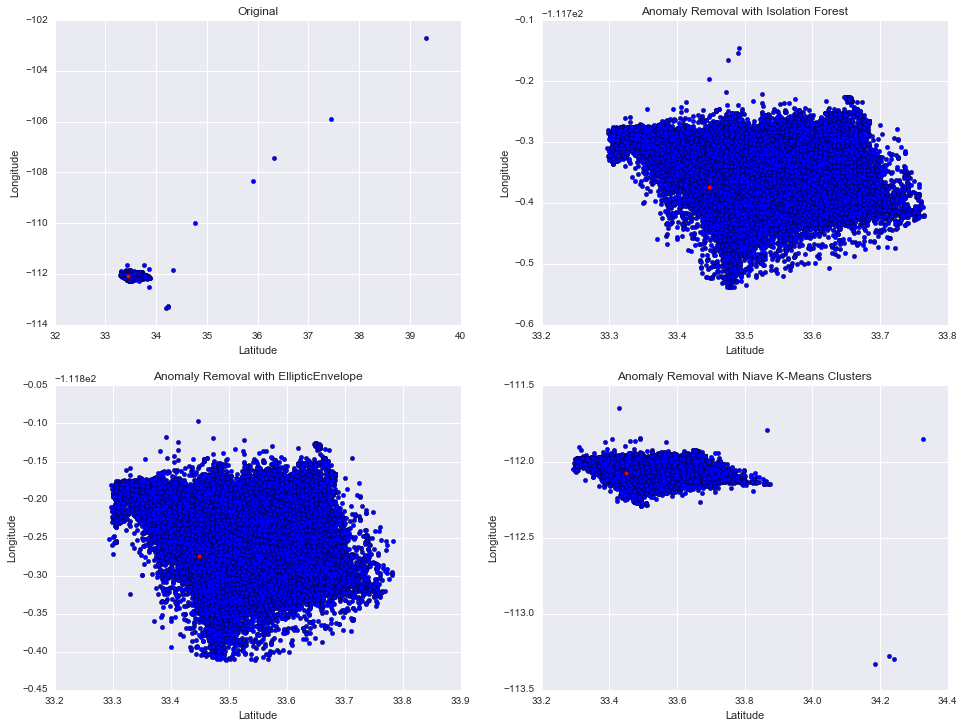

Naive K-Means Clusters predicted a radius of: 8.9329
Elliptic Envelope predicted a radius of: 8.9421
Isolation Forest predicted a radius of: 8.9380


In [17]:
phoenix_reviews = get_all_reviews_by_user_for_city("Phoenix")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
visualize_centers(phoenix_reviews, (33.448, -112.074)).title("Original")
plt.subplot(2, 2, 2)
visualize_centers(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Isolation Forest")
plt.subplot(2, 2, 3)
visualize_centers(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with EllipticEnvelope")
plt.subplot(2, 2, 4)
visualize_centers(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Niave K-Means Clusters")

plt.show()

print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews))))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews))))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews))))